# Optimising the Optimisation
In this notebook, I look at how many inducing points, latent functions and LMC components I need to train the prediction model to beat a simple baseline.

I'll look at the ONeil dataset, in the LTO setting, using processed viability to predict the missing triplets. For comparison we use the simple Bliss non-interaction assumption.

Focussing on a single cell line, and a subset of the drugs, I can quickly get a sense of how many latent functions I need and how many inducing points they need.

In [176]:
import torch
import gpytorch
import pimogp
from pimogp.utils.utils import train_test_split_drugdata, prepdata
from pimogp.utils.runModel import runmodel

In [177]:
# Set some parameters
input_type = "processed"
targets = "fMean"
predtarget = "viability"
dataset = "ONeil"
seed = 12
setting = "LTO"
data, train, test, ids = train_test_split_drugdata(input_type=input_type,dataset=dataset,setting=setting,seed=seed)

In [178]:
# Just subset the data here to see if the number of inducing points were the issue
drugList = data["drugA"].unique()[0:5]

In [179]:
drugList

array(['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'Bortezomib'],
      dtype=object)

In [180]:
train = train[train['drugA'].isin(drugList)]
train = train[train['drugB'].isin(drugList)]
test = test[test['drugA'].isin(drugList)]
test = test[test['drugB'].isin(drugList)]

In [181]:
train['cell_line'].unique()

array(['A2058', 'A2780', 'A375', 'A427', 'CAOV3', 'COLO320DM', 'DLD1',
       'EFM192B', 'ES2', 'HCT116', 'HT144', 'HT29', 'KPL1', 'LNCAP',
       'LOVO', 'MDAMB436', 'MSTO', 'NCIH1650', 'NCIH2122', 'NCIH23',
       'NCIH460', 'NCIH520', 'OCUBM', 'OV90', 'OVCAR3', 'PA1', 'RKO',
       'RPMI7951', 'SKMEL30', 'SKMES1', 'SKOV3', 'SW620', 'SW837', 'T47D',
       'UACC62', 'UWB1289', 'UWB1289BRCA1', 'VCAP', 'ZR751'], dtype=object)

In [94]:
train

,cell_line,drugA,drugB,drugA_conc,drugB_conc,GPMean,GPVar,fMean,fVar,p0Mean,...,Blatent_247,Blatent_248,Blatent_249,Blatent_250,Blatent_251,Blatent_252,Blatent_253,Blatent_254,Blatent_255,task_index
100,A2058,5-FU,AZD1775,0.0,0.000000,-0.013604,1.045780,0.999671,0.000001,0.999978,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
101,A2058,5-FU,AZD1775,0.0,0.111111,-0.019983,1.011360,0.999656,0.000004,0.999977,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
102,A2058,5-FU,AZD1775,0.0,0.222222,-0.035324,0.974131,0.999599,0.000016,0.999961,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
103,A2058,5-FU,AZD1775,0.0,0.333333,-0.055318,0.939041,0.999442,0.000015,0.999812,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
104,A2058,5-FU,AZD1775,0.0,0.444444,-0.069008,0.890884,0.997371,0.000023,0.998224,...,-0.171792,-0.051740,-2.050742,-0.289099,0.343276,-0.289370,-0.034100,-2.101314,0.116015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840495,ZR751,Bortezomib,BEZ-235,1.0,0.555556,-0.141017,0.055194,0.236057,0.001203,0.258720,...,0.101134,-0.171971,-0.575043,-0.425517,0.047446,0.332179,-0.232644,-1.571546,-0.010968,38
1840496,ZR751,Bortezomib,BEZ-235,1.0,0.666667,0.114984,0.050149,0.229259,0.001062,0.208783,...,0.101134,-0.171971,-0.575043,-0.425517,0.047446,0.332179,-0.232644,-1.571546,-0.010968,38
1840497,ZR751,Bortezomib,BEZ-235,1.0,0.777778,0.426133,0.046356,0.221210,0.000855,0.158127,...,0.101134,-0.171971,-0.575043,-0.425517,0.047446,0.332179,-0.232644,-1.571546,-0.010968,38
1840498,ZR751,Bortezomib,BEZ-235,1.0,0.888889,0.711543,0.064786,0.205070,0.001108,0.114290,...,0.101134,-0.171971,-0.575043,-0.425517,0.047446,0.332179,-0.232644,-1.571546,-0.010968,38


In [182]:
# Will focus on a single cell line, A2058
cell_line = "A2058"
train = train[train['cell_line'] == cell_line]
#train = train.iloc[0:5000]
test = test[test['cell_line'] == cell_line] 
#test = test.iloc[0:5000]
y_train, X_train, train_indices, train_noise, train_weights = prepdata(train, targets, predtarget,num_latents=256)
y_test, X_test, test_indices, test_noise, test_weights = prepdata(test, targets, predtarget,num_latents=256)

In [183]:
X_train[0:5]

tensor([[ 0.0000,  0.0000, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.1111, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.2222, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.3333, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.4444, -0.5473,  ..., -0.0341, -2.1013,  0.1160]])

In [184]:
X_train.shape

torch.Size([800, 514])

In [185]:
X_test.shape

torch.Size([200, 514])

In [390]:
G = 1
num_latents = 2
num_inducing = 300
batch_size = 256
num_tasks = train_indices.max()+1
num_epochs = 400
initial_lr = 0.01
num_drug_latents = 256

In [391]:
from torch.utils.data import TensorDataset,  DataLoader
train_dataset = TensorDataset(X_train,y_train,train_noise,train_indices)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

# Define the permutation
permutation = torch.cat([torch.tensor([1]), torch.tensor([0]),
                             torch.linspace((2 + num_drug_latents), 1 + (2 * num_drug_latents), num_drug_latents), 
                         torch.linspace(2, 1 + num_drug_latents, num_drug_latents)]).long()


In [392]:
next(iter(train_loader))

[tensor([[ 0.3333,  0.6667, -0.5972,  ..., -0.2326, -1.5715, -0.0110],
         [ 0.8889,  0.1111, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
         [ 0.6667,  0.4444, -0.5473,  ..., -0.7600, -1.8868, -0.4474],
         ...,
         [ 0.3333,  0.6667,  0.6334,  ..., -0.2326, -1.5715, -0.0110],
         [ 0.6667,  1.0000, -0.5473,  ..., -0.2326, -1.5715, -0.0110],
         [ 0.1111,  0.8889, -0.5473,  ..., -0.0341, -2.1013,  0.1160]]),
 tensor([4.5404e-01, 7.2710e-01, 9.7222e-01, 1.9991e-01, 9.8906e-01, 4.8492e-01,
         2.0893e-01, 9.9826e-01, 4.7505e-01, 2.8803e-01, 9.9893e-01, 9.8265e-04,
         9.9262e-01, 9.9815e-01, 5.9477e-01, 7.1715e-01, 9.8785e-01, 8.8239e-01,
         1.3620e-01, 9.9962e-01, 9.9722e-01, 9.5787e-01, 6.4597e-01, 1.2236e-01,
         9.9848e-01, 4.2690e-02, 9.9708e-01, 6.9664e-01, 9.7823e-01, 8.2622e-04,
         9.9780e-01, 4.0086e-01, 9.9967e-01, 4.3673e-02, 2.3217e-01, 9.9937e-01,
         9.9851e-01, 4.2487e-01, 2.2839e-01, 8.5072e-01, 1.5431e-01, 9.9

In [422]:
from torch import Tensor
from typing import Literal
from pimogp.kernels.permutation_invariant_rbf import PermutationInvariantRBFKernel
from pimogp.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy
from botorch.models.utils.inducing_point_allocators import GreedyVarianceReduction

class TestModel(gpytorch.models.ApproximateGP):
    r"""
    DrugComboModelICM_NC is the model for drug combination prediction that utilizes drug covariates, but
    no cell line covariates

    It wraps a PermutationInvariantVariationalStrategy in an LMCVariationalStrategy for a multi-output GP.
    The parameters of the LMC are learned "free-form" as opposed to making use of cell line information

    :param permutation: A Tensor giving the permutation the function should be invariant to
    :param conc_dims: The dimensions of the data input that corresponds to the drug concentrations
    :param drug_covar_dims: The dimension of the data input that corresponds to the drug covariates
    :param num_tasks: The number of tasks / outputs / cell lines
    :param num_latents: The number of latent functions in the LMC
    :param num_inducing: The number of inducing points per latent
    :param sample_inducing_from: A Tensor to sample inducing points from, usually this would be the training inputs
    :param inducing_weights: A vector of weights used in sampling of the inducing points
    :param vardistr: The variational distribution to use, mf=MeanField (Default), "nat"=Natural, "chol"=Cholesky
    """

    def __init__(self, permutation: Tensor,
                 num_tasks: int,
                 num_latents: int,
                 num_inducing: int,
                 inducing_weights,
                 sample_inducing_from: Tensor,
                 ):

        
        covar_module = gpytorch.kernels.ScaleKernel(PermutationInvariantRBFKernel(permutation=permutation,permute_forward=True,
                                                     ard_num_dims=514,lengthscale_constraint=gpytorch.constraints.LessThan(100.0)))

        # Initialise the lengthscales
        div = torch.zeros([514])
        div[0:2] = 2.0
        div[2:] = 2.0
        lengthscales_init = sample_inducing_from.var(dim=0).sqrt().div(div)
        covar_module.base_kernel.lengthscale = lengthscales_init


        # Sample inducing points
        #p = inducing_weights.div(inducing_weights.sum())
        #idx = p.multinomial(num_samples=num_inducing * num_latents, replacement=False).reshape(num_latents,
        #                                                                                       num_inducing)
        #inducing_points = sample_inducing_from[idx]

        ind_allocator = GreedyVarianceReduction()
        inducing_points = torch.empty((0, num_inducing, sample_inducing_from.size(1)))
        for i in range(num_latents):
            sample = ind_allocator.allocate_inducing_points(sample_inducing_from, covar_module,
                                                num_inducing=num_inducing, input_batch_shape=torch.Size([]))
            inducing_points = torch.cat((inducing_points, sample.unsqueeze(0)), dim=0)
            matches = (sample_inducing_from.unsqueeze(1) == sample).all(dim=2)
            row_matches = matches.any(dim=1)
            sample_inducing_from = sample_inducing_from[~row_matches]
        #inducing_points = ind_allocator.allocate_inducing_points(sample_inducing_from,
        #                                                         covar_module,num_inducing=num_inducing,
        #                                                         input_batch_shape=torch.Size([num_latents]))

        # Now turn of the permutation forward
        #covar_module.permute_forward = False
        
        # Variational distribution
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
            )

        # Variational Strategy
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
            #PermutationInvariantVariationalStrategy(
                self, inducing_points, variational_distribution,
                #permutation,
                learn_inducing_locations=True),
            num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1)

        super(TestModel, self).__init__(variational_strategy)

        # Store permutation here
        

        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ConstantMean()
        # Covar over the concentrations, simple RBF
        #self.covar_module_concentrations = covar_module_concentrations
        # Covar over the drugs, RBF + ARD
        #self.covar_module_drugs = covar_module_drugs
        self.covar_module = covar_module



    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        #covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [423]:
# Set up model and likelihood
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
model = TestModel(permutation=permutation, num_tasks = num_tasks, num_latents=num_latents, num_inducing=num_inducing,sample_inducing_from=X_train,inducing_weights=train_weights)
likelihood = GaussianLikelihood()
#likelihood = FixedNoiseGaussianLikelihood(noise=torch.tensor([0.01]))

Index 0 given to:  (0, 1)
Index 1 given to:  (2, 258)
Index 2 given to:  (3, 259)
Index 3 given to:  (4, 260)
Index 4 given to:  (5, 261)
Index 5 given to:  (6, 262)
Index 6 given to:  (7, 263)
Index 7 given to:  (8, 264)
Index 8 given to:  (9, 265)
Index 9 given to:  (10, 266)
Index 10 given to:  (11, 267)
Index 11 given to:  (12, 268)
Index 12 given to:  (13, 269)
Index 13 given to:  (14, 270)
Index 14 given to:  (15, 271)
Index 15 given to:  (16, 272)
Index 16 given to:  (17, 273)
Index 17 given to:  (18, 274)
Index 18 given to:  (19, 275)
Index 19 given to:  (20, 276)
Index 20 given to:  (21, 277)
Index 21 given to:  (22, 278)
Index 22 given to:  (23, 279)
Index 23 given to:  (24, 280)
Index 24 given to:  (25, 281)
Index 25 given to:  (26, 282)
Index 26 given to:  (27, 283)
Index 27 given to:  (28, 284)
Index 28 given to:  (29, 285)
Index 29 given to:  (30, 286)
Index 30 given to:  (31, 287)
Index 31 given to:  (32, 288)
Index 32 given to:  (33, 289)
Index 33 given to:  (34, 290)
I

In [424]:
likelihood.noise

tensor([0.6932], grad_fn=<AddBackward0>)

In [425]:
model.covar_module.lengthscale

In [426]:
model.variational_strategy.base_variational_strategy.inducing_points.shape

torch.Size([2, 300, 514])

In [427]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[-0.3586],
        [-0.0680]], requires_grad=True)

In [428]:
from torch.optim.lr_scheduler import MultiStepLR
from gpytorch.mlls import VariationalELBO
# Now define the loss and set up the optimization
hyperparameter_optimizer = None
variational_ngd_optimizer = None
scheduler_hypers = None
scheduler_variational = None
vardistr = "nat"
if vardistr == "nat":
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr = initial_lr)
    variational_ngd_optimizer = gpytorch.optim.NGD(
        model.variational_parameters(),
        num_data=y_train.size(0), lr=float(10*initial_lr))
    scheduler_variational = MultiStepLR(variational_ngd_optimizer,
                                        milestones=[int(0.25*num_epochs),int(0.5*num_epochs),int(0.75*num_epochs)],
                                        gamma=0.5)
else:
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=initial_lr)

scheduler_hypers = MultiStepLR(hyperparameter_optimizer,
                               milestones=[int(0.25*num_epochs),int(0.5 * num_epochs), int(0.75 * num_epochs)],
                               gamma=0.5)

# Defining the loss:
mll = VariationalELBO(likelihood,model,num_data=y_train.size(0))

# Tracking loss
train_loss = []

In [429]:
from tqdm.autonotebook import tqdm
# Begin training
with gpytorch.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False), gpytorch.settings.debug(state=False):
    epochs_iter = tqdm(range(num_epochs),desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch, y_noise_batch, task_batch in minibatch_iter:
            # Zero gradients
            hyperparameter_optimizer.zero_grad()
            if variational_ngd_optimizer is not None:
                variational_ngd_optimizer.zero_grad()
    
            # Get outputs
            output = model(x_batch,task_indices=task_batch)
            
    
            # Compute loss
            if isinstance(likelihood, gpytorch.likelihoods.FixedNoiseGaussianLikelihood):
                loss = -mll(output, y_batch, noise=(y_noise_batch+0.01))
            else:
                loss = -mll(output, y_batch)
            # Call backward on loss
            loss.backward()
            # Take a step
            hyperparameter_optimizer.step()
            if variational_ngd_optimizer is not None:
                variational_ngd_optimizer.step()
    
            # Update counter
            minibatch_iter.set_postfix(loss=loss.item(),drug1_lengthscale = model.covar_module.base_kernel.lengthscale[0][2].item())
    
            # Track loss
            train_loss.append(loss.item())
    
        # Step learning rate scheduler
        scheduler_hypers.step()
        if scheduler_variational is not None:
            scheduler_variational.step()

Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/4 [00:00<?, ?it/s]

In [431]:
model.covar_module.base_kernel.lengthscale

tensor([[0.3278, 0.3278, 4.3123, 3.2260, 2.6736, 2.4603, 2.9276, 3.9157, 2.5560,
         5.5297, 2.9988, 2.5882, 6.2686, 3.1836, 3.1349, 3.2010, 4.0596, 3.2352,
         3.1765, 2.6713, 5.0791, 3.6905, 2.1766, 4.8370, 1.2798, 3.5768, 3.5727,
         1.7800, 3.0340, 3.0093, 4.0914, 3.3627, 2.8279, 3.1208, 3.3111, 4.6096,
         2.3167, 2.1251, 2.4554, 2.9041, 2.7429, 3.5168, 2.3078, 3.4514, 3.2777,
         2.7910, 3.5833, 1.7619, 2.5396, 3.1725, 3.7984, 3.2655, 2.9213, 4.6029,
         3.2290, 2.5670, 2.4277, 3.4013, 2.8624, 3.4936, 5.1867, 4.3270, 1.2715,
         4.4116, 2.2598, 3.5364, 3.4415, 2.0678, 3.2622, 2.7444, 4.3211, 3.3926,
         3.9292, 3.2079, 3.0110, 2.0425, 3.0676, 3.2440, 2.2454, 2.7250, 2.7896,
         4.2207, 2.7694, 2.3356, 3.2514, 1.2494, 2.7268, 3.3791, 3.4333, 4.1440,
         3.4172, 3.7002, 3.2104, 3.5510, 4.4007, 2.4629, 2.0730, 3.2617, 4.4094,
         3.4291, 3.1265, 3.9765, 2.3030, 3.6744, 3.6535, 2.6131, 2.5862, 2.0865,
         1.4636, 3.3556, 2.6

In [432]:
likelihood.noise

tensor([0.0047], grad_fn=<AddBackward0>)

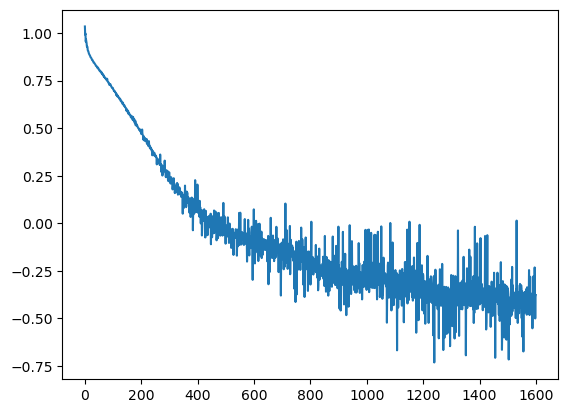

In [433]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.log(1.6+torch.tensor(train_loss)))

In [434]:
X_test

tensor([[ 0.0000,  0.0000, -0.5473,  ...,  0.3296, -1.5032, -0.0834],
        [ 0.0000,  0.1111, -0.5473,  ...,  0.3296, -1.5032, -0.0834],
        [ 0.0000,  0.2222, -0.5473,  ...,  0.3296, -1.5032, -0.0834],
        ...,
        [ 1.0000,  0.7778, -0.5972,  ..., -0.7600, -1.8868, -0.4474],
        [ 1.0000,  0.8889, -0.5972,  ..., -0.7600, -1.8868, -0.4474],
        [ 1.0000,  1.0000, -0.5972,  ..., -0.7600, -1.8868, -0.4474]])

In [435]:
X_train

tensor([[ 0.0000,  0.0000, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.1111, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.2222, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        ...,
        [ 1.0000,  0.7778,  0.6334,  ..., -0.2326, -1.5715, -0.0110],
        [ 1.0000,  0.8889,  0.6334,  ..., -0.2326, -1.5715, -0.0110],
        [ 1.0000,  1.0000,  0.6334,  ..., -0.2326, -1.5715, -0.0110]])

In [459]:
X_test[0:100,] = X_train[0:100,]

In [460]:
#test_dataset = TensorDataset(X_train, train_indices)
test_dataset = TensorDataset(X_test, test_indices)
test_loader = DataLoader(test_dataset, batch_size=256)

# Set into eval mode
model.eval()
likelihood.eval()
yhat = []
yvar = []
print("Predicting at test inputs")
with torch.no_grad(), gpytorch.settings.cholesky_max_tries(12):
    minibatch_iter = tqdm(test_loader,desc="Minibatch", leave=False)
    for x_batch, task_batch in minibatch_iter:
        predictions = (model(x_batch, task_indices=task_batch))
        mean = predictions.mean
        var = predictions.variance
        yhat.append(mean)
        yvar.append(var)
        

yhat_vector = torch.cat(yhat, 0)
yvar_vector = torch.cat(yvar,0)

Predicting at test inputs


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

In [461]:
x_batch

tensor([[ 0.0000,  0.0000, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.1111, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        [ 0.0000,  0.2222, -0.5473,  ..., -0.0341, -2.1013,  0.1160],
        ...,
        [ 1.0000,  0.7778, -0.5972,  ..., -0.7600, -1.8868, -0.4474],
        [ 1.0000,  0.8889, -0.5972,  ..., -0.7600, -1.8868, -0.4474],
        [ 1.0000,  1.0000, -0.5972,  ..., -0.7600, -1.8868, -0.4474]])

In [463]:
yhat_vector

tensor([0.9842, 0.9773, 0.9878, 1.0190, 1.0170, 0.9047, 0.6547, 0.3370, 0.0872,
        0.0137, 1.0080, 0.9856, 0.9896, 1.0287, 1.0418, 0.9364, 0.6759, 0.3373,
        0.0740, 0.0080, 1.0102, 0.9769, 0.9768, 1.0223, 1.0468, 0.9470, 0.6810,
        0.3318, 0.0654, 0.0110, 1.0067, 0.9707, 0.9696, 1.0167, 1.0419, 0.9385,
        0.6657, 0.3131, 0.0531, 0.0141, 1.0007, 0.9697, 0.9698, 1.0122, 1.0267,
        0.9102, 0.6297, 0.2809, 0.0357, 0.0152, 0.9800, 0.9572, 0.9594, 0.9935,
        0.9921, 0.8617, 0.5791, 0.2433, 0.0190, 0.0153, 0.9285, 0.9120, 0.9155,
        0.9424, 0.9299, 0.7955, 0.5243, 0.2120, 0.0101, 0.0147, 0.8408, 0.8256,
        0.8290, 0.8524, 0.8392, 0.7169, 0.4734, 0.1940, 0.0123, 0.0129, 0.7283,
        0.7097, 0.7113, 0.7340, 0.7289, 0.6318, 0.4290, 0.1894, 0.0258, 0.0131,
        0.6128, 0.5891, 0.5871, 0.6089, 0.6139, 0.5465, 0.3897, 0.1942, 0.0503,
        0.0232, 0.4273, 0.4275, 0.4278, 0.4290, 0.4287, 0.4221, 0.4066, 0.3852,
        0.3655, 0.3549, 0.4280, 0.4273, 

In [464]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[-4.5227e-01],
        [-3.6562e-04]], requires_grad=True)

In [465]:
model.covar_module

ScaleKernel(
  (base_kernel): PermutationInvariantRBFKernel(
    (raw_lengthscale_constraint): LessThan(1.000E+02)
  )
  (raw_outputscale_constraint): Positive()
)

In [466]:
print("our error: ",(y_train - yhat_vector).square().mean().sqrt())
print("baseline error: ",(y_train-torch.tensor(train["f"].values)).square().mean().sqrt())

RuntimeError: The size of tensor a (800) must match the size of tensor b (200) at non-singleton dimension 0

In [467]:
print("our error: ",(y_test - yhat_vector).square().mean().sqrt())
print("baseline error: ",(y_test-torch.tensor(test["p0Mean"].values)).square().mean().sqrt())

our error:  tensor(0.4380)
baseline error:  tensor(0.0303, dtype=torch.float64)


our error:  tensor(0.3859, dtype=torch.float64)
baseline error:  tensor(0.0374, dtype=torch.float64)


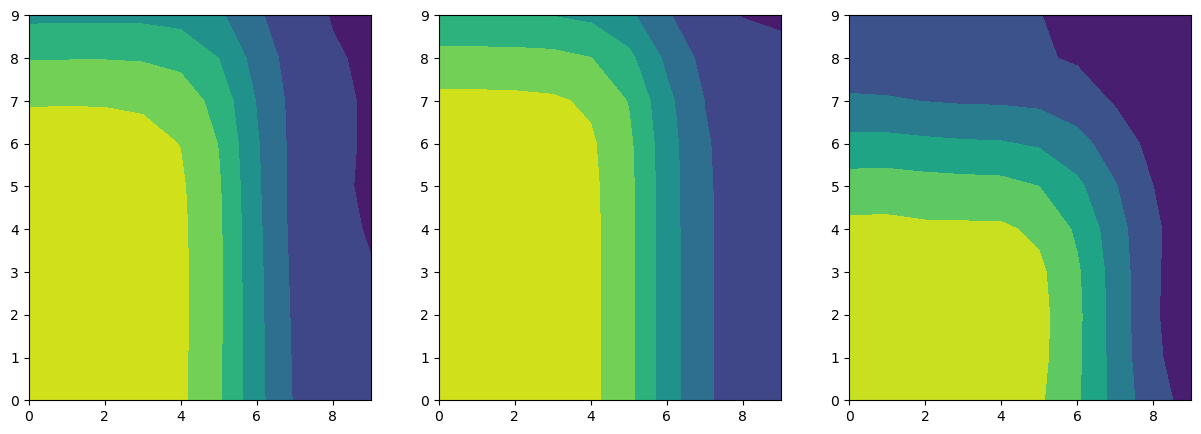

In [472]:
start = 100
end = start + 100

fhat = yhat_vector[start:end].reshape(10,10)
var = yvar_vector[start:end].reshape(10,10)
f = torch.tensor(train.iloc[start:end,7].values).reshape(10,10)
p0 = torch.tensor(train.iloc[start:end,9].values).reshape(10,10)
print("our error: ",(fhat-f).square().mean().sqrt())
print("baseline error: ",(p0-f).square().mean().sqrt())

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
axes[0].contourf(f)
axes[1].contourf(p0)
axes[2].contourf(fhat)
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im,cax=cbar_ax)

#axes[0].set_title("True values")
#axes[1].set_title("Baseline")
#axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'True values')

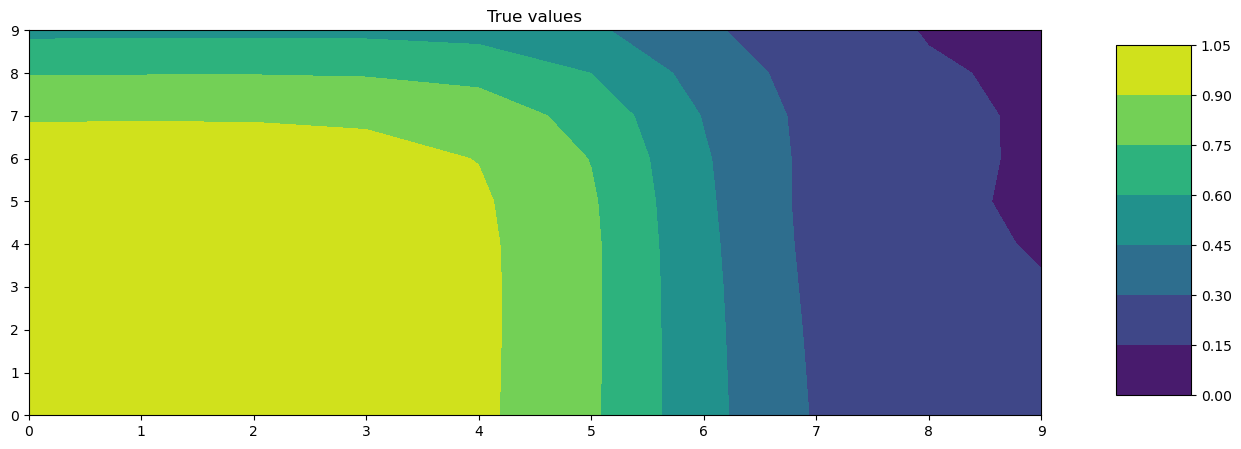

In [473]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
axes.contourf(f)
#axes[1].contourf(p0)
#axes[2].contourf(fhat)
im = axes.contourf(f)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

axes.set_title("True values")
#axes[1].set_title("Baseline")
#axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'Baseline')

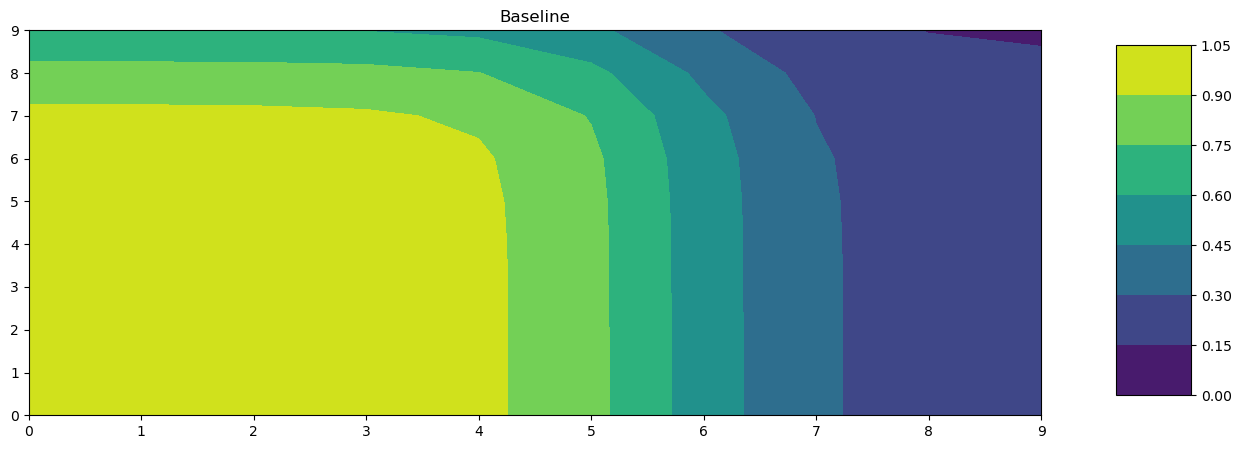

In [474]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
#axes.contourf(f)
axes.contourf(p0)
#axes[2].contourf(fhat)
im = axes.contourf(p0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

#axes.set_title("True values")
axes.set_title("Baseline")
#axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'Our Prediction')

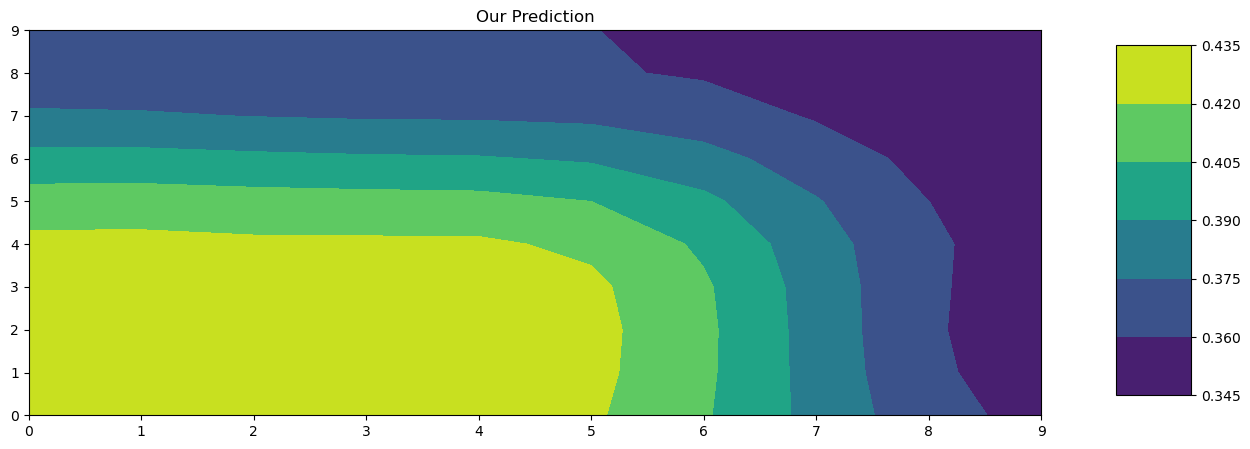

In [475]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
#axes.contourf(f)
#axes.contourf(p0)
axes.contourf(fhat)
im = axes.contourf(fhat)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

#axes.set_title("True values")
#axes.set_title("Baseline")
axes.set_title("Our Prediction")

In [458]:
fhat

tensor([[0.3935, 0.3938, 0.3941, 0.3943, 0.3934, 0.3903, 0.3846, 0.3779, 0.3727,
         0.3707],
        [0.3942, 0.3942, 0.3943, 0.3946, 0.3939, 0.3907, 0.3848, 0.3777, 0.3722,
         0.3705],
        [0.3943, 0.3940, 0.3940, 0.3943, 0.3938, 0.3907, 0.3846, 0.3773, 0.3719,
         0.3706],
        [0.3942, 0.3939, 0.3937, 0.3940, 0.3935, 0.3904, 0.3842, 0.3769, 0.3716,
         0.3706],
        [0.3942, 0.3939, 0.3938, 0.3940, 0.3933, 0.3901, 0.3838, 0.3764, 0.3712,
         0.3703],
        [0.3939, 0.3938, 0.3937, 0.3939, 0.3931, 0.3897, 0.3834, 0.3761, 0.3709,
         0.3700],
        [0.3929, 0.3929, 0.3929, 0.3930, 0.3922, 0.3888, 0.3828, 0.3758, 0.3707,
         0.3696],
        [0.3906, 0.3906, 0.3907, 0.3909, 0.3901, 0.3871, 0.3817, 0.3753, 0.3707,
         0.3694],
        [0.3872, 0.3870, 0.3871, 0.3874, 0.3869, 0.3845, 0.3800, 0.3747, 0.3707,
         0.3694],
        [0.3832, 0.3828, 0.3828, 0.3831, 0.3830, 0.3813, 0.3779, 0.3739, 0.3708,
         0.3698]])

In [229]:
p0

tensor([[1.0000, 1.0000, 1.0000, 0.9998, 0.9982, 0.9799, 0.7896, 0.2170, 0.0456,
         0.0301],
        [0.9999, 0.9999, 0.9999, 0.9998, 0.9982, 0.9799, 0.7896, 0.2170, 0.0456,
         0.0301],
        [0.9998, 0.9998, 0.9998, 0.9997, 0.9981, 0.9798, 0.7895, 0.2170, 0.0456,
         0.0301],
        [0.9994, 0.9994, 0.9994, 0.9993, 0.9977, 0.9794, 0.7892, 0.2169, 0.0456,
         0.0300],
        [0.9983, 0.9983, 0.9983, 0.9981, 0.9965, 0.9783, 0.7883, 0.2167, 0.0455,
         0.0300],
        [0.9944, 0.9944, 0.9944, 0.9943, 0.9927, 0.9745, 0.7852, 0.2158, 0.0453,
         0.0299],
        [0.9812, 0.9812, 0.9812, 0.9811, 0.9795, 0.9616, 0.7748, 0.2130, 0.0447,
         0.0295],
        [0.9356, 0.9356, 0.9356, 0.9355, 0.9340, 0.9169, 0.7388, 0.2031, 0.0427,
         0.0281],
        [0.8028, 0.8028, 0.8028, 0.8027, 0.8014, 0.7868, 0.6340, 0.1743, 0.0366,
         0.0241],
        [0.6052, 0.6052, 0.6052, 0.6051, 0.6041, 0.5931, 0.4779, 0.1314, 0.0276,
         0.0182]], dtype=tor

In [217]:
(fhat-f).abs()

tensor([[0.0128, 0.0061, 0.0066, 0.0039, 0.0057, 0.0113, 0.0154, 0.0142, 0.0064,
         0.0079],
        [0.0079, 0.0073, 0.0083, 0.0072, 0.0077, 0.0076, 0.0054, 0.0018, 0.0024,
         0.0081],
        [0.0210, 0.0178, 0.0248, 0.0301, 0.0319, 0.0328, 0.0324, 0.0290, 0.0230,
         0.0172],
        [0.0004, 0.0009, 0.0122, 0.0198, 0.0210, 0.0177, 0.0109, 0.0008, 0.0088,
         0.0130],
        [0.0405, 0.0492, 0.0448, 0.0423, 0.0456, 0.0528, 0.0614, 0.0678, 0.0662,
         0.0520],
        [0.0042, 0.0271, 0.0362, 0.0433, 0.0511, 0.0568, 0.0573, 0.0493, 0.0287,
         0.0056],
        [0.1898, 0.1673, 0.1520, 0.1392, 0.1316, 0.1335, 0.1452, 0.1660, 0.1942,
         0.2263],
        [0.0295, 0.0430, 0.0287, 0.0260, 0.0222, 0.0281, 0.0148, 0.0764, 0.0778,
         0.1132],
        [0.1015, 0.0863, 0.0910, 0.1020, 0.1038, 0.0900, 0.0676, 0.0488, 0.0441,
         0.0583],
        [0.0653, 0.0810, 0.0713, 0.0560, 0.0523, 0.0633, 0.0783, 0.0835, 0.0706,
         0.0370]], dtype=tor

Text(0.5, 1.0, 'Predictive variance')

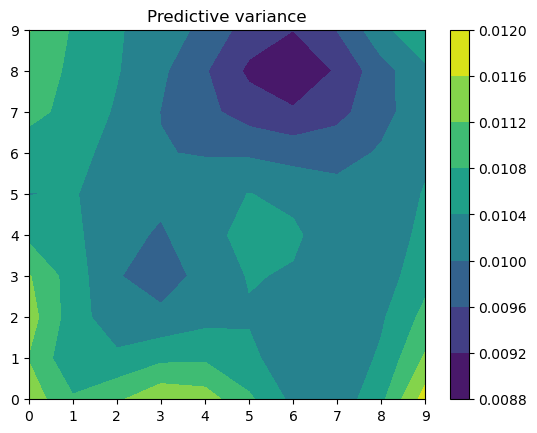

In [29]:
plt.contourf(var)
plt.colorbar()
plt.title("Predictive variance")